# UZOP Projekt

## Druga faza - replikacija rezultata

Cilj 2. faze projekta jest:
    - korištenjem dostupnih alata i metoda u članku replicirati dobivene rezultate
    - objasniti eventualne razlike u rezultatima

In [23]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.svm import SVC
import math

Prije objašnjavanja rezultata, važno je napomenuti da su neki studenti skinuli svoj Empatica E4 sat jer su ranije završili pisanje ispita.

Radi razumijevanja i jasnoće, na početku smo ispisali sve ocjene studenata na ispitima.

In [24]:
points_file = open('StudentGrades.txt', 'r')
lines = points_file.readlines()
lines = [line.rstrip() for line in lines]
lines = [line for line in lines if line]
lines

['GRADES - MIDTERM 1',
 '------------------',
 'S1 - 78',
 'S2 - 82',
 'S3 - 77',
 'S4 - 75',
 'S5 - 67',
 'S6 - 71',
 'S7 - 64',
 'S8 - 92',
 'S9 - 80',
 'S10 - 89',
 'GRADES - MIDTERM 2',
 '------------------',
 'S1 - 82',
 'S2 - 85',
 'S3 - 90',
 'S4 - 77',
 'S5 - 77',
 'S6 - 64',
 'S7 - 33',
 'S8 - 88',
 'S9 - 39',
 'S10 - 64',
 'GRADES - FINAL (OUT OF 200)',
 '---------------------------',
 'S1 - 182',
 'S2 - 180',
 'S3 - 188',
 'S4 - 149',
 'S5 - 157',
 'S6 - 175',
 'S7 - 110',
 'S8 - 184',
 'S9 - 126',
 'S10 - 116']

Radi kasnijeg korištenja, kreirani su rječnici za svaki ispit koji sadrže ocjene za svakog studenta na dotičnom ispitu.

In [26]:
midterm_points = {}
midterm2_points = {}
final_points = {}

for i, line in enumerate(lines):
    if "MIDTERM 1" in line:
        for midterm_line in lines[i+2:i+12]:
            student = midterm_line
            if 'S10' in student:
                student = midterm_line[:3]
            else:
                student = midterm_line[:2]
            grade = midterm_line[-2:]
            midterm_points[student] = int(grade)
            
    if 'MIDTERM 2' in line:
        for midterm2_line in lines[i+2:i+12]:
            student = midterm2_line
            if 'S10' in student:
                student = midterm2_line[:3]
            else:
                student = midterm2_line[:2]
            grade = midterm2_line[-2:]
            midterm2_points[student] = int(grade)
            
    if 'FINAL' in line:
        for final_line in lines[i+2:i+12]:
            student = final_line
            if 'S10' in student:
                student = final_line[:3]
            else:
                student = final_line[:2]
            grade = final_line[-3:]
            final_points[student] = int(grade)/2

final_points

{'S1': 91.0,
 'S2': 90.0,
 'S3': 94.0,
 'S4': 74.5,
 'S5': 78.5,
 'S6': 87.5,
 'S7': 55.0,
 'S8': 92.0,
 'S9': 63.0,
 'S10': 58.0}

Budući da je svaki student stavio sat 5 minuta prije pisanja ispita. Zbog toga, na podatacima na y-osi akcelerometra na satu mogu se vidjeti određene oscilacije, koje je potrebno ukloniti jer mogu imati loš utjecaj na točnost mjerenja. Navedeni grafovi prikazuju podatke y-osi akcelerometra za svakog studenta na svakom ispitu.

In [48]:
# test = ["Midterm 1", "Midterm 2", "Final"]
# #plt.figure(figsize=(18,18))
# for i in range (1, 11):
#     for j in range(len(test)):
#         accY_s1m1 = pd.read_csv ('Data/S' + str(i) + '/' + test[j] + '/ACC.csv')
#         #print(accY_s1m1)
#         accY_s1m1 = accY_s1m1[accY_s1m1.columns[1]]
#         #display(accY_s1m1)
#         sample_rate = 32
#         accY_s1m1 = accY_s1m1.iloc[1:]

#         #da se vidi di rezat - moze se zumirat sa npr plt.xlim(0, 50000)
#         plt.figure(figsize=(18, 5))
#         plt.xlim(0, 50000)
#         plt.title(f"S{i}, test: {test[j]}")
#         plt.plot(accY_s1m1)

Iz gornjih grafova intuitivno su uzeta područja koja će biti od interesa u analizi zbog mogućeg lošeg utjecaja na rezultate. Počeci tih područja navedeni su u idućoj ćeliji.

In [7]:
midterm1_beginning = {
    'S1': 46650,
    'S2': 47300,
    'S3': 45292,
    'S4': 46235,
    'S5': 48080,
    'S6': 44500,
    'S7': 45304,
    'S8': 46190,
    'S9': 46677,
    'S10': 47950
}

# midterm2_beginning = {
#     'S1': 8428,
#     'S2': 11800,
#     'S3': 13553,
#     'S4': 9570,
#     'S5': 10291,
#     'S6': 66650,
#     'S7': 68758,
#     'S8': 69449,
#     'S9': 45166,
#     'S10': 65053
# }

midterm2_beginning = {
    'S1': 66650,
    'S2': 66650,
    'S3': 66650,
    'S4': 66650,
    'S5': 66650,
    'S6': 66650,
    'S7': 66650,
    'S8': 66650,
    'S9': 66650,
    'S10': 66650
}

final_beginning = {
    'S1': 35808,
    'S2': 36130,
    'S3': 1265,
    'S4': 24880,
    'S5': 1282,
    'S6': 44114,
    'S7': 37090,
    'S8': 23962,
    'S9': 47787,
    'S10': 47950
}

U članku je navedeno da se za dobivanje linije trenda vodljivosti kože koristi niskopropunsi FIR filtar. Stoga, definirana je funkcija lowpass_butter_filter() koja implementira funkcionalnost filtra. Također, definirane su i cutoff frekvencije za ekstrakciju navedenih linija trenda. Iznosi frekvencija očitani su iz tablice u članku.

In [27]:
from scipy.signal import butter, filtfilt

def lowpass_butter_filter(data, cutoff, sampling_frequency, order=4):
    nyq = 0.5 * sampling_frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data, axis=0)

    return pd.DataFrame(y, columns=[data.columns[0]])

In [28]:
cutoff_freq = pd.DataFrame(
    {
        'Midterm 1': [0.002, 0.002, 0.0002, 0.002, 0.001, 0.002, 0.001, 0.0002, 0.002, 0.002],
        'Midterm 2': [0.002, 0.001, 0.0002, 0.002, 0.001, 0.002, 0.0002, 0.002, 0.002, 0.002],
        'Final': [0.002, 0.002, 0.001, 0.002, 0.001, 0.002, 0.0002, 0.002, 0.002, 0.002],
    }
)
cutoff_freq

,Midterm 1,Midterm 2,Final
0,0.0020,0.0020,0.0020
1,0.0020,0.0010,0.0020
2,0.0002,0.0002,0.0010
3,0.0020,0.0020,0.0020
4,0.0010,0.0010,0.0010
5,0.0020,0.0020,0.0020
6,0.0010,0.0002,0.0002
7,0.0002,0.0020,0.0020
8,0.0020,0.0020,0.0020
9,0.0020,0.0020,0.0020


Koristeći postupke opisane u odjeljku II.D u članku, određene su značajke za pojedine studente za pojedini ispit.

In [29]:
#Konačni feature list extractain iz odrezanog EDA
def feature_engineer_from_test(test, time_read, cutoff_freq, acc_beginning):
    all_students = []
    removable_eda_samples = []#lista odrezanih data sampleova svakog studneta
    for i in range (1, 11):      
        #ucitavanje, uzimanje y stupca, micanje retka sa frekvencijom
        accY = pd.read_csv('Data/S' + str(i) + '/' + str(test) + '/ACC.csv')
        accY = accY[accY.columns[1]]
        accY = accY.iloc[1:]


        student = 'S'+str(i)
        start = acc_beginning[student]
        #rezanje accY
        accY = accY.iloc[start:]

        #racunanje koliko smo vremena odrezali iza accY
        accY_sample_rate = 32
        eda_sample_rate = 4
        time_accY = start / accY_sample_rate
        print(time_accY)

        #racunanje koliko mjerenja iz eda treba maknut na temelju vremena i sample_ratea
        eda_samples_to_remove = math.floor(time_accY * eda_sample_rate)
        removable_eda_samples.append(eda_samples_to_remove)
        print(eda_samples_to_remove)

        df = pd.read_csv ('Data/S' + str(i) + '/' + str(test) + '/EDA.csv')
        df = df.iloc[eda_samples_to_remove:]
        cutoff = cutoff_freq.at[i-1, test]
        df = lowpass_butter_filter(df, cutoff, 4.000)
        data =[]
        for j in df.values:
            data.append (j)
        range1 = int(time_read*60*4)


        first_data = data[0:range1]
        second_data = data[int(len(data)/2) - int(range1/2) : int(len(data)/2) + int(range1/2)]
        third_data = data[len(data) - range1 : len(data)]

        mi1 = np.mean (first_data)
        mi2 = np.mean (second_data)
        mi3 = np.mean (third_data)

        sigma1 = np.var (first_data)
        sigma2 = np.var (second_data)
        sigma3 = np.var (third_data)

        ro = mi2 / (mi1 + mi3)

        diff = np.array(third_data) - np.array(first_data)
        mi_diff = np.mean (diff)
        sigma_diff = np.var (diff)

        x = [mi1, mi2, mi3, sigma1, sigma2, sigma3, ro, mi_diff, sigma_diff]
        all_students.append(x)
    return pd.DataFrame(all_students), removable_eda_samples

In [30]:
#FEATURE ENGINEERING
time_reads = [5,15,30]
tests = ['Midterm 1', 'Midterm 2', 'Final']


midterm1_5min, remove_eda_m1 = feature_engineer_from_test('Midterm 1', 5, cutoff_freq, midterm1_beginning)
midterm1_15min, remove_eda_m1 = feature_engineer_from_test('Midterm 1', 15, cutoff_freq, midterm1_beginning)
midterm1_30min, remove_eda_m1 = feature_engineer_from_test('Midterm 1', 30, cutoff_freq, midterm1_beginning)

midterm2_5min, remove_eda_m2 = feature_engineer_from_test('Midterm 2', 5, cutoff_freq, midterm2_beginning)
midterm2_15min, remove_eda_m2 = feature_engineer_from_test('Midterm 2', 15, cutoff_freq, midterm2_beginning)
midterm2_30min, remove_eda_m2 = feature_engineer_from_test('Midterm 2', 30, cutoff_freq, midterm2_beginning)

final_5min, remove_eda_f = feature_engineer_from_test('Final', 5, cutoff_freq, final_beginning)
final_15min, remove_eda_f = feature_engineer_from_test('Final', 15, cutoff_freq, final_beginning)
final_30min, remove_eda_f = feature_engineer_from_test('Final', 30, cutoff_freq, final_beginning)

1457.8125
5831
1478.125
5912
1415.375
5661
1444.84375
5779
1502.5
6010
1390.625
5562
1415.75
5663
1443.4375
5773
1458.65625
5834
1498.4375
5993
1457.8125
5831
1478.125
5912
1415.375
5661
1444.84375
5779
1502.5
6010
1390.625
5562
1415.75
5663
1443.4375
5773
1458.65625
5834
1498.4375
5993
1457.8125
5831
1478.125
5912
1415.375
5661
1444.84375
5779
1502.5
6010
1390.625
5562
1415.75
5663
1443.4375
5773
1458.65625
5834
1498.4375
5993
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
2082.8125
8331
1119.0
4476
1129.0625
4516
39.53125
158
777.5
3110
40.0625
160
1378.5625
5514
1159.0625
4636
748.8125
2995
1493.34375


Konačno, grafički su prikazane linije trenda srednjih vrijednosti vodljivosti kože za studente po ispitima.

In [31]:
#plottanje mean SC trendlinea
def plot_SC_exam(removable_eda, test, file):
    eda_lengths = []
    for i in range(1,11):
        eda_df = pd.read_csv('Data/S' + str(i) + '/' + str(test) + '/' + file)
        eda_lengths.append(len(eda_df))
    ending = min(eda_lengths)
    start = max(removable_eda)
    
    eda_points_list = [0] * (ending-start)
    for i in range(1,11):
        eda_df = pd.read_csv('Data/S' + str(i) + '/' + str(test) + '/' + file)
        eda_df = eda_df[start:ending]
        for j, value in enumerate(eda_df.values):
            eda_points_list[j]+=value
    mean_sc = [val/10 for val in eda_points_list]
    x = [i for i in range(ending-start)]
    plt.plot(x, mean_sc)

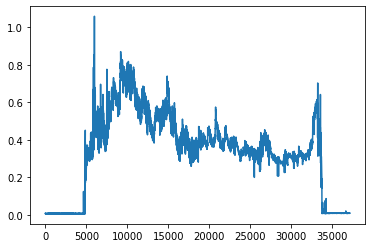

In [17]:
plot_SC_exam(remove_eda_m1, 'Midterm 1', 'EDA.csv')

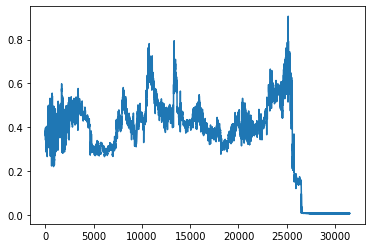

In [18]:
plot_SC_exam(remove_eda_m2, 'Midterm 2', 'EDA.csv')

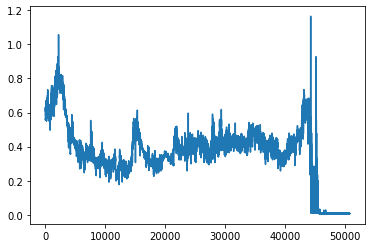

In [19]:
plot_SC_exam(remove_eda_f, 'Final', 'EDA.csv')

Također, prikazan je odnos srednjih vrijednosti vodljivosti kože za dvije klase studenata s obzirom na uspjeh na ispitu (barem 80% ili manje).

In [36]:
#plottanje mean SC trendlinea
def plot_SC_exam_for_HG(removable_eda, test, points_dict, file):
    eda_lengths = []
    higher_grade_students = []
    hg_removable_eda = []
    
    for student, grade in points_dict.items():
        if grade >= 80:
            higher_grade_students.append(student)
            hg_removable_eda.append(removable_eda[int(student[-1])])
    for student in higher_grade_students:
        eda_df = pd.read_csv('Data/' + student + '/' + str(test) + '/' + file)
        eda_lengths.append(len(eda_df))
        
    ending = min(eda_lengths)
    start = max(hg_removable_eda)
    
    eda_points_list = [0] * (ending-start)
    for student in higher_grade_students:
        eda_df = pd.read_csv('Data/' + student + '/' + str(test) + '/' + file)
        eda_df = eda_df[start:ending]
        for j, value in enumerate(eda_df.values):
            eda_points_list[j]+=value
    mean_sc = [val/len(hg_removable_eda) for val in eda_points_list]
    x = [i for i in range(ending-start)]
    plt.plot(x, mean_sc, label="High grade")
    
#plottanje mean SC trendlinea
def plot_SC_exam_for_LG(removable_eda, test, points_dict, file):
    eda_lengths = []
    lower_grade_students = []
    lg_removable_eda = []
    
    for student, grade in points_dict.items():
        if grade < 80:
            lower_grade_students.append(student)
            lg_removable_eda.append(removable_eda[int(student[-1])])
            
    for student in lower_grade_students:
        eda_df = pd.read_csv('Data/' + student + '/' + str(test) + '/' + file)
        eda_lengths.append(len(eda_df))
    ending = min(eda_lengths)
    start = max(lg_removable_eda)
    
    eda_points_list = [0] * (ending-start)
    for student in lower_grade_students:
        eda_df = pd.read_csv('Data/' + student + '/' + str(test) + '/' + file)
        eda_df = eda_df[start:ending]
        for j, value in enumerate(eda_df.values):
            eda_points_list[j]+=value
    mean_sc = [val/len(lg_removable_eda) for val in eda_points_list]
    x = [i for i in range(ending-start)]
    plt.plot(x, mean_sc, label="Low grade")

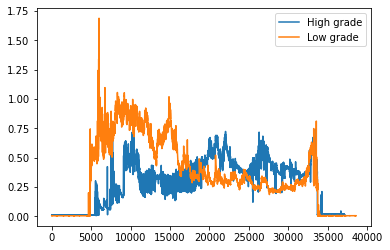

In [37]:
plt.figure()
plot_SC_exam_for_HG(remove_eda_m1, 'Midterm 1', midterm_points, 'EDA.csv')
plot_SC_exam_for_LG(remove_eda_m1, 'Midterm 1', midterm_points, 'EDA.csv')
plt.legend()

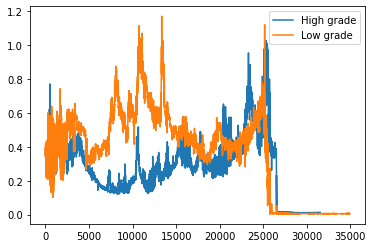

In [38]:
plt.figure()
plot_SC_exam_for_HG(remove_eda_m2, 'Midterm 2', midterm2_points, 'EDA.csv')
plot_SC_exam_for_LG(remove_eda_m2, 'Midterm 2', midterm2_points, 'EDA.csv')
plt.legend()

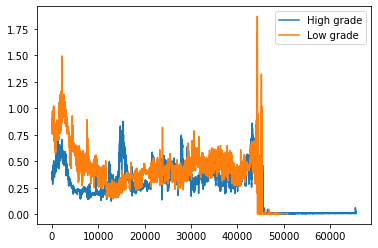

In [39]:
plt.figure()
plot_SC_exam_for_HG(remove_eda_f, 'Final', final_points, 'EDA.csv')
plot_SC_exam_for_LG(remove_eda_f, 'Final', final_points, 'EDA.csv')
plt.legend()

Potom su prikazane linije trenda srednje vrijednosti temperature kože za studente po ispitima te njihov odnos s obzirom na dvije navedene klase.

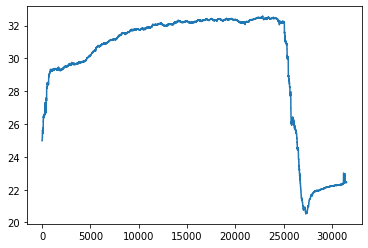

In [40]:
plot_SC_exam(remove_eda_m2, 'Midterm 2', 'TEMP.csv')

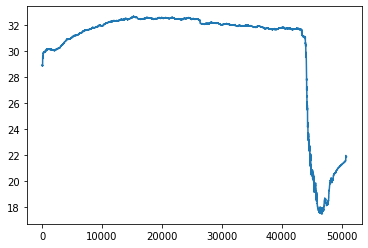

In [41]:
plot_SC_exam(remove_eda_f, 'Final', 'TEMP.csv')

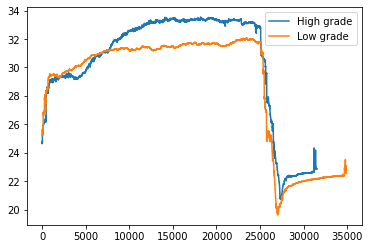

In [42]:
plt.figure()
plot_SC_exam_for_HG(remove_eda_m2, 'Midterm 2', midterm2_points, 'TEMP.csv')
plot_SC_exam_for_LG(remove_eda_m2, 'Midterm 2', midterm2_points, 'TEMP.csv')
plt.legend()

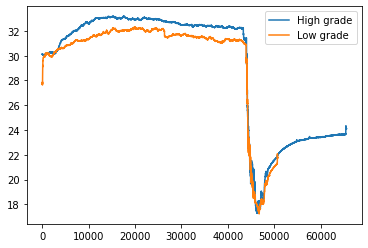

In [43]:
plt.figure()
plot_SC_exam_for_HG(remove_eda_f, 'Final', final_points, 'TEMP.csv')
plot_SC_exam_for_LG(remove_eda_f, 'Final', final_points, 'TEMP.csv')
plt.legend()

In [44]:
#LABEL ENGINEERING
def label_engineering(points_data):
    y = []
    for el in points_data:
        if(points_data[el] >= 80):
            y.append(1)
        else:
            y.append(0)
    #print(pd.DataFrame(y))
    return pd.DataFrame(y)

midterm_y = label_engineering(midterm_points)
midterm2_y = label_engineering(midterm2_points)
final_y = label_engineering(final_points)           

In [45]:
print(midterm1_15min)

          0         1         2             3         4             5  \
0  0.024309  0.146724  0.026885  1.570488e-07  0.002854  1.889410e-06   
1  0.012315  0.328770  0.013813  3.470515e-07  0.012429  9.957509e-07   
2  0.142202  0.179196  0.270388  4.584087e-03  0.000039  2.613740e-07   
3  0.008222  0.122902  0.000060  5.204824e-04  0.000168  1.952573e-08   
4 -0.008931  0.173713 -0.000853  1.425699e-03  0.000278  1.693918e-06   
5 -0.000012  1.181541  0.005511  1.959602e-08  0.016280  1.660114e-04   
6  0.000277  0.230773  0.000059  4.496461e-06  0.000804  2.584379e-07   
7  0.016551  0.753663  0.849201  2.167874e-04  0.003382  1.289554e-06   
8  0.013682  0.316363  0.014406  2.354538e-06  0.000304  3.433232e-08   
9  0.019633  0.365778  0.022173  6.028830e-08  0.000044  7.326629e-07   

            6         7         8  
0    2.866047  0.002576  0.000002  
1   12.582885  0.001498  0.000002  
2    0.434318  0.128186  0.004642  
3   14.839988 -0.008162  0.000520  
4  -17.754705  0

## Klasifikacija

Na kraju je pomoću algoritma k najbližih susjeda i 10-erostruke unakrsne provjere određena klasifikacija primjera te su ispisane njihove točnosti. Pritom vrijednosti od 5 i 15 minuta predstavljaju vremenski raspon prozora kojim je očitavana vodljivost s početka, sredine i kraja mjerenja.

In [46]:
def KNN_for_specific_data(dataframe, y):
    kf = KFold(n_splits=10)
    print(kf.split(dataframe))
    score = []
    for i, (train_index, test_index) in enumerate(kf.split(dataframe)):
        # print(f"Fold {i}:")
        # print(f"  Train: index={train_index}")
        # print(f"  Test:  index={test_index}")
        
        x_train = dataframe.loc[train_index]
        x_test = dataframe.loc[test_index]
        y_train = y.loc[train_index]
        y_test = y.loc[test_index]
    
        neigh = KNeighborsClassifier(n_neighbors=3).fit(np.array(x_train), np.array(y_train))
        #neigh = SVC(kernel='poly').fit(np.array(x_train), np.array(y_train))
        score.append(neigh.score(x_test, y_test))
    return (score.count(1.0)/len(score)) * 100

In [47]:
print(f"Točnost za Midterm 1 (5 min): {KNN_for_specific_data(midterm1_5min, midterm_y)} %")
print(f"Točnost za Midterm 1 (15 min): {KNN_for_specific_data(midterm1_15min, midterm_y)} %") 

print(f"Točnost za Midterm 2 (5 min): {KNN_for_specific_data(midterm2_5min, midterm2_y)} %")
print(f"Točnost za Midterm 2 (15 min): {KNN_for_specific_data(midterm2_15min, midterm2_y)} %") 

print(f"Točnost za Final (5 min): {KNN_for_specific_data(final_5min, final_y)} %")
print(f"Točnost za Final (15 min): {KNN_for_specific_data(final_15min, final_y)} %")

<generator object _BaseKFold.split at 0x0000022FF255AAC0>


c:\Users\eleko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eleko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eleko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eleko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: Data

Točnost za Midterm 1 (5 min): 50.0 %
<generator object _BaseKFold.split at 0x0000022F951F2040>
Točnost za Midterm 1 (15 min): 50.0 %
<generator object _BaseKFold.split at 0x0000022F951F2040>
Točnost za Midterm 2 (5 min): 60.0 %
<generator object _BaseKFold.split at 0x0000022F951F2040>


c:\Users\eleko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eleko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eleko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eleko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: Data

Točnost za Midterm 2 (15 min): 60.0 %
<generator object _BaseKFold.split at 0x0000022F951F2040>
Točnost za Final (5 min): 20.0 %
<generator object _BaseKFold.split at 0x0000022F951F2040>
Točnost za Final (15 min): 20.0 %


c:\Users\eleko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\eleko\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


### NAPOMENA
Dobiveni rezultati i grafovi se ne poklapaju u potpunosti s onima u članku. Razlog tome jest naša intuicija i pristranost pri očitavanju početka područja od interesa za y-os podataka s akcelerometra. Također, izgledno je da postoje određene informacije koje su autori članka koristili, a da nama nisu bile dostupne.